In [78]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

### Общая информация

In [ ]:
#Константные и вариативные переменные
c_1 = tf.constant([1,2,3,4,5],dtype = tf.float16)
c_2 = tf.cast(a,dtype = tf.int32)

v_1 = tf.Variable([[1,2,3,4,5]])
v_2 = tf.Variable([[9,8,7,6,5]])

tf.gather(v_1[0],[0,2,4]) # Выбрать элементы тензора по индексам 
v_2[0][2] # Обратиться к элементу тензора
v_2[0][0:2] # Обратиться срезу
tf.reshape(v_1,[5,1]) #Изменить форму
v_2T = tf.transpose(v_2, perm =[1,0]) # трансформируем тензор

# Форматы
tf.zeros((2,2)) # тензор из 0
tf.ones((2,2)) # тензор из 1
tf.ones_like(v_2) # тензор из 1, размерности как..
tf.eye(3) # кдиничный тензор
tf.fill((2,2),-10) # c заданной размерности со значениями ..
tf.range(1,11,0.5)

# Генерация
tf.random.normal((2,4),0,0.1)
tf.random.uniform((2,4),1,10)
tf.random.truncated_normal((2,4),0,0.1) # нормальное но на +-2сигмы

# Математические функции
v_1 + v_2
v_1 - v_2
v_1 / v_2
v_1 // v_2
v_1 * v_2
v_1 **2
tf.tensordot(v_1[0], v_2[0], axes = 0) #каждый элемент одной на все элементы другой
tf.tensordot(v_1[0], v_2[0], axes = 1) #каждый с каждым по одному индесу и сумма всех

tf.reduce_sum(v_1,axis=[0,1]) #сумма внутри матриц
tf.reduce_max(v_1,axis=[0,1]) #максимальный
tf.reduce_mean(v_1,axis=[0,1]) #средний
tf.reduce_prod(v_1) #перемножение всех

#### Построим функцию, а потом попробуем подобрать коэф. с помощью TENSOR

Строим искомую функцию - y

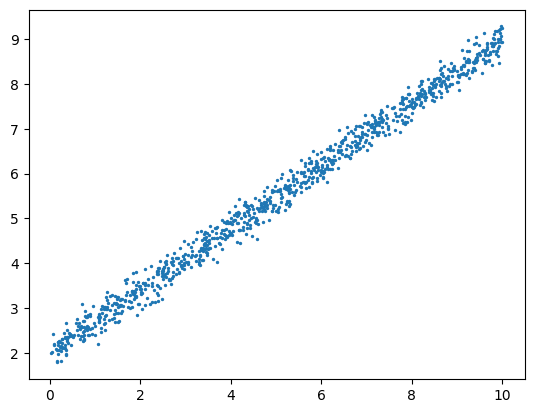

In [3]:
TOTAL_POINTS = 1000
x = tf.random.uniform(shape = [TOTAL_POINTS], minval =0, maxval = 10)
noise = tf.random.normal(shape = [TOTAL_POINTS],stddev=0.2)

k_true =0.7 # коэффициенты которые нужно предсказать
b_true = 2.0 # коэффициенты которые нужно предсказать

y = x*k_true +b_true +noise

plt.scatter(x,y,s=2)
plt.show()

Реализуем через стохастический градиентный спуск (МИНИ - БАТЧИ)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7042726> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9915617>


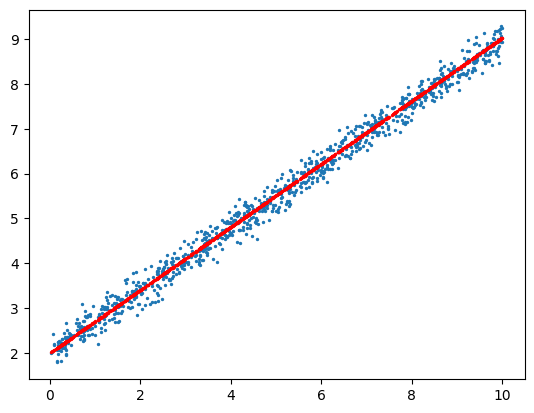

In [4]:
k = tf.Variable(0.0) # инициируем вариативную переменную 
b = tf.Variable(0.0) # инициируем вариативную переменную 

EPOCHS =50 
learning_rate = 0.02
BATCH_SIZE = 100
num_step = TOTAL_POINTS//BATCH_SIZE

for n in range(EPOCHS):
    for n_batch in range(num_step):
        y_batch = y[n_batch*BATCH_SIZE: (n_batch+1)*BATCH_SIZE]
        x_batch = x[n_batch*BATCH_SIZE: (n_batch+1)*BATCH_SIZE]
        
        with tf.GradientTape() as tape:
            f = k*x_batch + b
            loss = tf.reduce_mean(tf.square(y_batch-f))

        dk,db = tape.gradient(loss,[k,b]) # получаем 2 частные производные по k, b

        k.assign_sub(learning_rate*dk)
        b.assign_sub(learning_rate*db) 
    
print(k,b)

y_pr = x*k + b

plt.scatter(x,y,s =2)
plt.scatter(x,y_pr,c ='r',s =2)
plt.show()

Тоже самое, но со встроенным оптимизатором от TensorFlow.\
Добавляем к оптимизации метод моментов и метод Нестерова, ADAM и прочие

In [5]:
k = tf.Variable(0.0) # задаем вариативную переменную 
b = tf.Variable(0.0) # задаем вариативную переменную 

EPOCHS =50 
learning_rate = 0.02
BATCH_SIZE = 100
num_step = TOTAL_POINTS//BATCH_SIZE
#opt = tf.optimizers.SGD (learning_rate = 0.02, momentum = 0.5, nesterov = True) # оптимизатор с методом моментов
#opt = tf.optimizers.Adagrad (learning_rate = 0.02)
#opt = tf.optimizers.Adadelta (learning_rate = 4.0)
#opt = tf.optimizers.RMSprop (learning_rate = 0.01)
opt = tf.optimizers.Adam (learning_rate = 0.1)

for n in range(EPOCHS):
    for n_batch in range(num_step):
        y_batch = y[n_batch*BATCH_SIZE: (n_batch+1)*BATCH_SIZE]
        x_batch = x[n_batch*BATCH_SIZE: (n_batch+1)*BATCH_SIZE]
        
        with tf.GradientTape() as tape:
            f = k*x_batch + b
            loss = tf.reduce_mean(tf.square(y_batch-f))

        dk,db = tape.gradient(loss,[k,b]) # получаем 2 частные производные по k, b
        
        opt.apply_gradients(zip([dk,db], [k,b]))
        
print(k,b)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.69746953> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0065289>


### Простая нейронная сеть через TensorFlow

In [16]:
class DenseNN(tf.Module):
    def __init__(self,outputs):
        super().__init__()
        self.outputs = outputs
        self.fl_init = False
    def __call__(self,x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev =0.1, name = 'w')
            self.b = tf.zeros([self.outputs], dtype = tf.float32, name = 'b')
            
            self.w = tf.Variable(self.w) # преобразуем константные тензоры в переменные чтобы
            self.b = tf.Variable(self.b) # можно было вычислять по ним параметры градиентным спуском
            
            self.fl_init = True
        
        y = x@self.w + self.b
        return y

In [15]:
# Запустим необученную нейронную сеть подав на нее х = (1,2), но т.к. весовые коэффициенты инициализированы случайно, и сеть не обучена то получается bullshit 
model = DenseNN(1)
print (model(tf.constant([[1.0,2.0]])))

tf.Tensor([[-0.05406436]], shape=(1, 1), dtype=float32)


In [12]:
# Создадим обучающий сет
x_train = tf.random.uniform(minval = 0, maxval =10, shape = (100,2))
y_train = [a+b for a,b in x_train]

In [18]:
opt = tf.optimizers.Adam (learning_rate = 0.01)

In [19]:
def loss(y_pred,y_true):
    return tf.reduce_mean(tf.square(y_pred -y_true))

In [20]:
EPOCHS = 5
for n in range(EPOCHS):
    for x,y in zip(x_train,y_train):
        x = tf.expand_dims(x,axis =0)
        y = tf.constant(y,shape = (1,1))
        
        with tf.GradientTape() as tape:
            f_loss = loss(y, model(x))
            
        grads = tape.gradient(f_loss,model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
    print (f_loss.numpy())

4.412225
0.002836459
0.07757
0.10316907
0.115303926


In [21]:
print(model.trainable_variables)

(<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.9393344], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.92429656],
       [0.91778004]], dtype=float32)>)


# Нейросеть распознавания рукописного текста 

![title](img/mnist_2.jpg)

In [68]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

#### Подготовим данные для подачи в модель нейронной сети

In [69]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1,28*28])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1,28*28])
y_train = to_categorical(y_train,10) # One_hot вектор

#### Подготовим нейронную сеть. Полносвязаная, с 1 скрытым слоем

In [70]:
# один полновсвязный слой нейрнонной сети
class DenseNN(tf.Module): 
    def __init__(self,outputs, activate = 'relu'):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.fl_init = False
        
    def __call__(self,x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev =0.1, name = 'w')
            self.b = tf.zeros([self.outputs], dtype = tf.float32, name = 'b')
            
            self.w = tf.Variable(self.w) # преобразуем константные тензоры в переменные чтобы можно было вычислять по ним параметры градиентным спуском
            self.b = tf.Variable(self.b) # tf.Variable(self.b,trainble = False)
            
            self.fl_init = True
        
        y = x @ self.w + self.b # матричное умножение
        
        if self.activate == "relu":
            return tf.nn.relu(y) # функции встроены в tensorflow
        elif self.activate == "softmax":
            return tf.nn.softmax(y)
        return y
    
# класс самой модели   
class SequentialModule(tf.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = DenseNN(128)
        self.layer_2 = DenseNN(10,activate = 'softmax')
        
    def __call__(self, x):
        return self.layer_2(self.layer_1(x))    
    
# функция потерь   
def cross_entropy(y_true,y_pred):
    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true,y_pred))

# оптимизатор   
opt = tf.optimizers.legacy.Adam (learning_rate = 0.001)

In [71]:
model = SequentialModule()
print(model.submodules)

(<__main__.DenseNN object at 0x000001B2268CC1F0>, <__main__.DenseNN object at 0x000001B2268CC340>)


#### Запуск обучения

In [72]:
EPOCHS =10
BATCH_SIZE = 32
TOTAL = x_train.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(BATCH_SIZE)

@tf.function
def train_batch(x_batch, y_batch):
    with tf.GradientTape() as tape:
        f_loss = cross_entropy(y_batch, model(x_batch)) 
    
    grads = tape.gradient(f_loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return f_loss

for n in range(EPOCHS):
    loss =0 
    
    for x_batch, y_batch in train_dataset:
        loss += train_batch(x_batch, y_batch)

    print (loss.numpy())

495.77158
215.85617
144.82597
108.223305
81.14996
63.392277
48.817528
40.503777
32.39339
27.557337


Проверка на точность Accuracy

In [67]:
y = model(x_test)
y2 = tf.argmax(y,axis=-1).numpy()
acc = len(y_test[y_test==y2])/y_test.shape[0]*100
print(acc)

acc = tf.metrics.Accuracy()
acc.update_state(y2,y_test)
print(acc.result().numpy()*100)

97.96000000000001
97.96000123023987


### Подробнее про функцию декоратор перевода в графы

In [114]:
def function_tf(x,y):
    print('старт функции')
    s = tf.zeros_like(x, dtype = tf.float32)
    s = s +tf.matmul(x,y)
    for n in range(10):
        s = s +tf.matmul(s,y)*x
    return s


def test_function(fn):
    def wrapper(*args, **kwargs):
        start = time.time()
        for i in range(10):
            fn(*args, **kwargs)
        dt = time.time()-start
        print(f'Время обработки: {dt} сек')
    return wrapper

SIZE = 1000
x = tf.ones((SIZE,SIZE), dtype = tf.float32)
y = tf.ones_like(x,dtype = tf.float32)

function_tf_graph = tf.function(function_tf) 

test_function(function_tf)(x,y)
test_function(function_tf_graph)(x,y)

### Использование KERAS

In [160]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

#### Пример одного слоя 

In [165]:
'''Создаем слой унаслендованный от класса Layer с такими свойствами как
layer1.weights - тензор содержащий все веса слоя
layer1.trainable_weight тензор, содержащий все обучаемые веса слоя
layer1.non_trainable_variables тензор, содержащий все не обучаемые веса слоя'''

class DenseLayer(tf.keras.layers.Layer):
    def __init__(self,units=1): # по умолчанию 1 нейрон в полносвязном слое
        super().__init__()
        self.units = units
    def build(self, input_shape): # вызов для инициализации весовых коэф.
        self.w = self.add_weight(shape = (input_shape[-1],self.units),
                                initializer = 'random_normal',
                                trainable = True)
        self.b = self.add_weight(shape = (self.units,),
                                initializer = 'zeros',
                                trainable = True)
    def call(self, inputs):
        regular = tf.reduce_mean(tf.square(self.w)) #!!! добавлен к функции потерь слагаемое
        self.add_loss(regular)
        self.add_metric(regular, name = 'mean square weights')
        return tf.matmul(inputs,self.w)+self.b
    
# создаем экземляр слоя вызывая конструктор этого класса и протестируем подав набор значений
layer1 = DenseLayer(10)
print(layer1(tf.constant([[1.,2.,3.]])))

tf.Tensor(
[[-0.17486842 -0.14683728  0.2957731  -0.1424855   0.08495145 -0.1189972
   0.04858506  0.1500354  -0.15503603  0.0218898 ]], shape=(1, 10), dtype=float32)


#### Пример нескольких слоев

In [166]:
# наследует уже другой класс - модели, чтобы можно было обучать как модель нейросети. т.к. у модели есть метод compile
class Netw(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer_1 = DenseLayer(128)
        self.layer_2 = DenseLayer(10)
        
    def call (self,inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.layer_2(x)
        x = tf.nn.softmax(x)
        return x
    
model = Netw()
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
             loss = tf.losses.categorical_crossentropy,
             metrics = ['accuracy'])

In [168]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255

x_train = tf.reshape(tf.cast(x_train,tf.float32), [-1,28*28])
x_test = tf.reshape(tf.cast(x_test,tf.float32), [-1,28*28])

y_train = to_categorical(y_train,10)
y_test_cat = to_categorical(y_test,10)

model.fit(x_train,y_train,batch_size =32, epochs =5)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0857 - accuracy: 0.9841 - mean square weights: 0.0212
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0809 - accuracy: 0.9863 - mean square weights: 0.0211
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0763 - accuracy: 0.9884 - mean square weights: 0.0209
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0736 - accuracy: 0.9890 - mean square weights: 0.0207
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0710 - accuracy: 0.9900 - mean square weights: 0.0205
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0689 - accuracy: 0.9912 - mean square weights: 0.0203
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0669 - accuracy: 0.9923 - mean square weights: 0.0201
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 

In [159]:
print (model.evaluate(x_test,y_test_cat))

313/313 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9782
[0.07612086832523346, 0.9782000184059143]
